In [1]:
!pip install exoplanet

     |████████████████████████████████| 41 kB 112 kB/s 
     |████████████████████████████████| 211 kB 14.4 MB/s 


In [2]:
import exoplanet as xo

In [4]:
!pip install lightkurve

     |████████████████████████████████| 245 kB 6.6 MB/s 
     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 41 kB 231 kB/s 
     |████████████████████████████████| 4.4 MB 39.4 MB/s 
     |████████████████████████████████| 98 kB 8.2 MB/s 
     |████████████████████████████████| 802 kB 31.8 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 3.2 MB 37.7 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=6a655f2036a64dc1adb4c9aaf593aa6090694d0fea69dbd721d832f6def7bfc0
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50466 sha256=bd5535805f677206defbda46818252b5c9bb84e24cb7299c3df8985fc274cc12
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995dbf11db6cede602e7ef
  Created wheel for okt

In [6]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits

/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


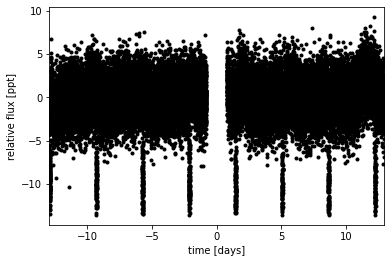

In [8]:
lc_file = lk.search_lightcurve('WASP-101', mission='TESS', sector=33).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
lc = lc_file.remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

# For the purposes of this example, we'll discard some of the data
m = (lc.quality == 0) & (
    np.random.default_rng(261136679).uniform(size=len(time)) < 0.3
)

with fits.open(lc_file.filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux[m] - 1.0), dtype=np.float64)

plt.plot(x, y, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

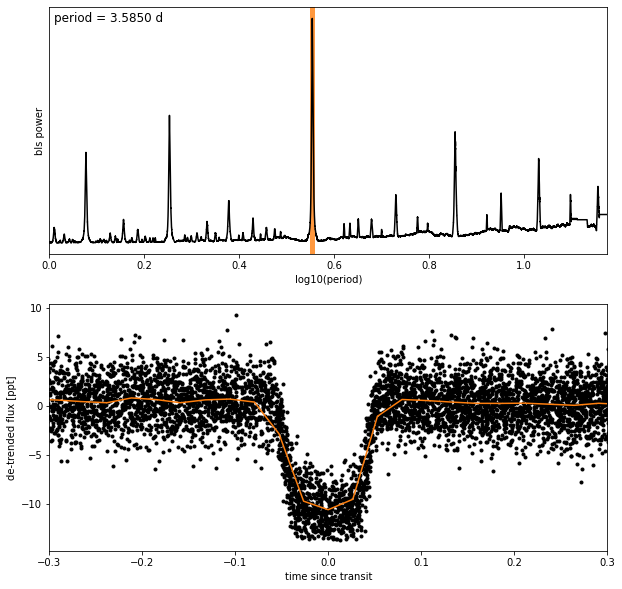

In [9]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], y[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

In [10]:

!pip install pymc3_ext

In [11]:
!pip install celerite2

     |████████████████████████████████| 864 kB 6.9 MB/s 


In [12]:
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from exo.mast
        M_star = 1.50, 0.03
        R_star = 1.44, 0.03
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star[0], sd=M_star[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star[0], sd=R_star[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        #         log_r_pl = pm.Normal(
        #             "log_r_pl",
        #             sd=1.0,
        #             mu=0.5 * np.log(1e-3 * np.array(bls_depth))
        #             + np.log(R_star_huang[0]),
        #         )
        #         r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        #         ror = pm.Deterministic("ror", r_pl / r_star)
        #         b = xo.distributions.ImpactParameter("b", ror=ror)

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
            * 1e3
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


model0, map_soln0, extras0 = build_model()

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -67490.29647669324 -> -65775.78925437239
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -65775.78925437239 -> -65761.79297902048
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -65761.79297902048 -> -65513.91524420595
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -65513.91524420595 -> -65499.83485507922
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -65499.834855079214 -> -65479.36876869101
optimizing logp for variables: [log_depth]


message: Desired error not necessarily achieved due to precision loss.
logp: -65479.36876869101 -> -65436.93330438636
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -65436.93330438636 -> -65415.30650780468
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -65415.30650780468 -> -65414.124076572705
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -65414.124076572705 -> -65412.1812416598
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: -65412.1812416598 -> -65023.846889533954
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -65023.846889533954 -> -64955.10846018688


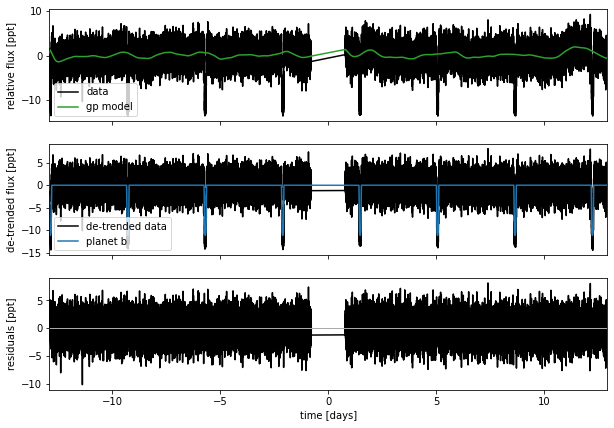

In [13]:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln0, extras0)
